# Examples

## Example 1

This is a polynomial optimization problem of commutative variables mentioned in Section 5.12 of Henrion et. al (2009). We rely on NumPy to remove the equality constraints from the problem

In [1]:
import numpy as np
from ncpol2sdpa import *

W = np.diag(np.ones(8), 1) + np.diag(np.ones(7), 2) + np.diag([1, 1], 7) + \
    np.diag([1], 8)
W = W + W.T
n = len(W)
e = np.ones(n)
Q = (np.diag(np.dot(e.T, W)) - W) / 4

x = generate_variables('x', n)
equalities = [xi ** 2 - 1 for xi in x]

objective = -np.dot(x, np.dot(Q, np.transpose(x)))

sdp = SdpRelaxation(x)
sdp.get_relaxation(1, objective=objective, equalities=equalities,removeequalities=True)
sdp.solve(solver='mosek')

In [2]:
print(sdp.primal, sdp.dual, sdp.status)

-13.500000000958572 -13.499999997662677 optimal


## Example 2: Parametric Polynomial Optimization Problems

In a parametric polynomial optimization problem, we can separate two sets of variables, and one set acts as a parameter to the problem. More formally, we would like to find the following function:

$$J(x) = \inf_{y \in \R^m}{\{f(x,y) \colon h_j(y) \geq 0, j=1,\dots,r\}}$$

where $x \in X = \{ x \in \R^n \colon h_k(x) \geq 0, k = r+1,\dots,t\}$. We can approximate $J(x)$ using the dual of an SDP relaxation. The following implements Example 4 from Lasserre (2010).

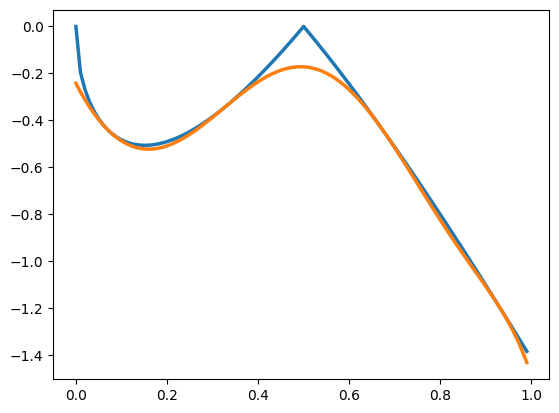

In [4]:
from math import sqrt
from sympy import integrate, N
import matplotlib.pyplot as plt

def J(x):
    return -2*abs(1-2*x)*sqrt(x/(1+x))

def Jk(x, coeffs):
    return sum(ci*x**i for i, ci in enumerate(coeffs))

level = 4
x = generate_variables('x')[0]
y = generate_variables('y', 2)
f = (1-2*x)*(y[0] + y[1])

gamma = [integrate(x**i, (x, 0, 1)) for i in range(1, 2*level+1)]
marginals = flatten([[x**i-N(gamma[i-1]), N(gamma[i-1])-x**i]
                    for i in range(1, 2*level+1)])

inequalities = [x*y[0]**2 + y[1]**2 - x,  - x*y[0]**2 - y[1]**2 + x,
                y[0]**2 + x*y[1]**2 - x,  - y[0]**2 - x*y[1]**2 + x,
                1-x, x]
sdp = SdpRelaxation(flatten([x, y]))
sdp.get_relaxation(level, objective=f, momentinequalities=marginals,
                   inequalities=inequalities)
sdp.solve(solver='mosek')
coeffs = [sdp.extract_dual_value(0, range(len(inequalities)+1))]
coeffs += [sdp.y_mat[len(inequalities)+1+2*i][0][0] - sdp.y_mat[len(inequalities)+1+2*i+1][0][0]
           for i in range(len(marginals)//2)]

x_domain = [i/100. for i in range(100)]
plt.plot(x_domain, [J(xi) for xi in x_domain], linewidth=2.5)
plt.plot(x_domain, [Jk(xi, coeffs) for xi in x_domain], linewidth=2.5)
plt.show()

## Example 3: Sparse Relaxation with Chordal Extension

This method replicates the behaviour of SparsePOP (Waki et. al, 2008). The following is a simple example:

In [6]:
level = 2
X = generate_variables('x', 3)

obj = X[1] - 2*X[0]*X[1] + X[1]*X[2]
inequalities = [1-X[0]**2-X[1]**2, 1-X[1]**2-X[2]**2]

sdp = SdpRelaxation(X)
sdp.get_relaxation(level, objective=obj, inequalities=inequalities,
                   chordal_extension=True)
sdp.solve(solver='mosek')
print(sdp.primal, sdp.dual)

-2.2443697115014705 -2.2443697019845184


## Example 4: Mixed-Level Relaxation of a Bell Inequality

It is often the case that moving to a higher-order relaxation is computationally prohibitive. For these cases, it is possible to inject extra monomials to a lower level relaxation. We refer to this case as a mixed-level relaxation.

As an example, we consider the CHSH inequality in the probability picture at level 1+AB relaxation. The lazy way of doing this is as follows:

This will immediately give you the negative of the maximum violation. The function maximum_violation only works for two-party configuration, so for educational purposes, we spell out what goes on in the background. With level and $I$ defined as above, we create the measurements that will make up the probabilities, and define the objective function with the $I$ matrix.

In [2]:
I = [[ 0,   -1,    0 ],
     [-1,    1,    1 ],
     [ 0,    1,   -1 ]]
level = 1
P = Probability([2, 2], [2, 2])
objective = define_objective_with_I(I, P)

Unfortunately, the function define_objective_with_I only works for two parties again, which is not surprising, as it would be hard to define an I matrix for more than two parties. So if you have a multipartite scenario, you can use the probabilities to define your Bell inequality. For the CHSH, it is

In [3]:
CHSH = -P([0],[0],'A') + P([0,0],[0,0])  + P([0,0],[0,1]) + P([0,0],[1,0]) - P([0,0],[1,1]) - P([0],[0],'B')

Note that we can only minimize a function, so we have to flip the sign to get the same objective function as above:

In [4]:
objective = -CHSH

We need to generate the monomials we would like to add to the relaxation. This is aided by a helper function in the class Probability. We only need to provide the strings we would like to see – this time it is AB:

In [6]:
sdp = SdpRelaxation(P.get_all_operators())
sdp.get_relaxation(level, objective=objective,
                   substitutions=P.substitutions,
                   extramonomials=P.get_extra_monomials('AB'))
sdp.solve(solver='mosek')
print(sdp.dual)

-0.2071067808121591


## NPA hierarchy

The following code replicates the toy example from Pironio, S.; Navascués, M. & Acín, A. Convergent relaxations of polynomial optimization problems with noncommuting variables SIAM Journal on Optimization, SIAM, 2010, 20, 2157-2180.

In [14]:
from ncpol2sdpa import generate_operators, SdpRelaxation

# Number of operators
n_vars = 2
# Level of relaxation
level = 2

# Get Hermitian operators
X = generate_operators('X', n_vars, hermitian=True)

# Define the objective function
obj = X[0] * X[1] + X[1] * X[0]

# Inequality constraints
inequalities = [-X[1] ** 2 + X[1] + 0.5]

# Simple monomial substitutions
substitutions = {X[0]**2: X[0]}

# Obtain SDP relaxation
sdpRelaxation = SdpRelaxation(X)
sdpRelaxation.get_relaxation(level, objective=obj, inequalities=inequalities,substitutions=substitutions)
sdpRelaxation.solve(solver='mosek')
print(sdpRelaxation.primal, sdpRelaxation.dual, sdpRelaxation.status)

-0.7499999993994902 -0.7499999936814759 optimal


## References

Bancal, J.D., L. Sheridan, and V. Scarani. 2014. “More Randomness from the Same Data.” New Journal of Physics 16 (3): 033011. doi:10.1088/1367-2630/16/3/033011.

Fayngold, M., and V. Fayngold. 2013. Quantum Mechanics and Quantum Information. Wiley-VCH.

Henrion, D., J. Lasserre and J. Löfberg. 2009. “GloptiPoly 3: Moments, Optimization and Semidefinite Programming.” Optimization Methods & Software, 24: 761–779.

Johansson, J.R., P.D. Nation, and Franco Nori. 2013. “QuTiP 2: A Python Framework for the Dynamics of Open Quantum Systems.” Computer Physics Communications 184 (4): 1234–40. doi:10.1016/j.cpc.2012.11.019.

Lasserre, J. B. 2010. “A Joint+Marginal Approach to Parametric Polynomial Optimization.” SIAM Journal on Optimization 20(4):1995–2022. doi:10.1137/090759240.

Moroder, Tobias, Jean-Daniel Bancal, Yeong-Cherng Liang, Martin Hofmann, and Otfried Gühne. 2013. “Device-Independent Entanglement Quantification and Related Applications.” Physics Review Letters 111 (3). American Physical Society: 030501. doi:10.1103/PhysRevLett.111.030501.

Navascués, M., A. García-Sáez, A. Acín, S. Pironio, and M.B. Plenio. 2013. “A Paradox in Bosonic Energy Computations via Semidefinite Programming Relaxations.” New Journal of Physics 15 (2): 023026. doi:10.1088/1367-2630/15/2/023026.

Nieto-Silleras, O., S. Pironio, and J. Silman. 2014. “Using Complete Measurement Statistics for Optimal Device-Independent Randomness Evaluation.” New Journal of Physics 16 (1): 013035. doi:10.1088/1367-2630/16/1/013035.

Pironio, S., M. Navascués, and A. Acín. 2010. “Convergent Relaxations of Polynomial Optimization Problems with Noncommuting Variables.” SIAM Journal on Optimization 20 (5). SIAM: 2157–80. doi:10.1137/090760155.

Sturm, J.F. 1999. “Using SeDuMi 1.02, a MATLAB Toolbox for Optimization over Symmetric Cones.” Optimization Methods and Software 11 (1-4): 625–53.

Waki, H.; S. Kim, M. Kojima, M. Muramatsu, and H. Sugimoto. 2008. “Algorithm 883: SparsePOP—A Sparse Semidefinite Programming Relaxation of Polynomial Optimization Problems.” ACM Transactions on Mathematical Software, 2008, 35(2), 15. doi:10.1145/1377612.1377619.

Yamashita, M., K. Fujisawa, and M. Kojima. 2003. “SDPARA: Semidefinite Programming Algorithm Parallel Version.” Parallel Computing 29 (8): 1053–67.